# Analyse des valeurs aberrantes dans le dataset OpenFoodFacts

Ce notebook présente une analyse comparative des différentes méthodes de détection des valeurs aberrantes sur le dataset OpenFoodFacts.

## 1. Importation des bibliothèques nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configuration de l'affichage
plt.style.use('default')
sns.set_theme()
sns.set_palette("husl")

# Importation des fonctions de détection des valeurs aberrantes
import sys
import os

# Ajout du répertoire racine au PYTHONPATH
current_dir = os.getcwd()
root_dir = os.path.dirname(current_dir)
sys.path.append(root_dir)

# Importation du module
from scripts.outlier_detection import (
    detect_outliers_tukey,
    detect_outliers_zscore,
    detect_outliers_elliptic,
    detect_outliers_isolation_forest,
    detect_outliers_lof
)

## 2. Chargement des données

In [ ]:
# Chargement des données
path = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz"
df = pd.read_csv(path, nrows=100000, sep='\t', encoding="utf-8")

# Affichage des informations sur le dataset
print("Informations sur le dataset :")
display(df.info())

# Affichage des premières lignes
print("\nAperçu des données :")
display(df.head())

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 206 entries, code to acidity_100g
dtypes: float64(131), int64(4), object(71)
memory usage: 15.7+ MB


C:\Users\omist\AppData\Local\Temp\ipykernel_10132\484772365.py:3: DtypeWarning: Columns (11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, nrows=10000, sep='\t', encoding="utf-8")


None


Aperçu des données :


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1740205422,2025-02-22T06:23:42Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1739902555,2025-02-18T18:15:55Z,waistline-app,1740360377,2025-02-24T01:26:17Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1740075018,2025-02-20T18:10:18Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1742247341,2025-03-17T21:35:41Z,roboto-app,1742247341,2025-03-17T21:35:41Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1738073570,2025-01-28T14:12:50Z,NaN,1740085032,2025-02-20T20:57:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Sélection des colonnes à analyser

Nous allons nous concentrer sur les colonnes nutritionnelles principales :

In [3]:
# Colonnes nutritionnelles à analyser
numeric_columns = ['energy-kcal_100g', 'fat_100g', 'proteins_100g', 'carbohydrates_100g']

# Affichage des statistiques descriptives
print("Statistiques descriptives des colonnes sélectionnées :")
display(df[numeric_columns].describe())

Statistiques descriptives des colonnes sélectionnées :


,energy-kcal_100g,fat_100g,proteins_100g,carbohydrates_100g
count,5504.000000,5297.000000,5327.000000,5420.00000
mean,295.601560,13.606621,15.538351,30.83748
std,527.018021,24.044791,47.030409,51.28016
min,0.000000,0.000000,0.000000,0.00000
25%,110.000000,1.454545,2.300000,6.67000
50%,277.888889,7.200000,7.470000,19.00000
75%,404.000000,18.784530,18.580000,48.00000
max,25300.000000,700.000000,1800.000000,2200.00000


## 4. Fonctions d'analyse et de visualisation

In [4]:
def plot_outliers_comparison(data, column, methods_results):
    """Crée un graphique comparant les différentes méthodes de détection"""
    fig = plt.figure(figsize=(15, 10))
    
    # Histogramme des données
    plt.subplot(2, 1, 1)
    df_plot = pd.DataFrame({column: data})
    sns.histplot(data=df_plot, x=column, bins=50)
    plt.title(f"Distribution des {column}")
    
    # Graphique des valeurs aberrantes
    plt.subplot(2, 1, 2)
    for method_name, (outliers, _) in methods_results.items():
        plt.scatter(data[~outliers], 
                   np.zeros_like(data[~outliers]) + list(methods_results.keys()).index(method_name),
                   alpha=0.5, label=f"Normal ({method_name})")
        plt.scatter(data[outliers],
                   np.zeros_like(data[outliers]) + list(methods_results.keys()).index(method_name),
                   alpha=0.5, label=f"Outlier ({method_name})")
    
    plt.yticks(range(len(methods_results)), list(methods_results.keys()))
    plt.title("Comparaison des valeurs aberrantes détectées")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return fig

def print_summary(methods_results):
    """Affiche un résumé des résultats pour chaque méthode"""
    print("\nRésumé des détections de valeurs aberrantes :")
    print("-" * 50)
    for method_name, (outliers, stats) in methods_results.items():
        n_outliers = np.sum(outliers)
        percentage = (n_outliers / len(outliers)) * 100
        print(f"\nMéthode : {method_name}")
        print(f"Nombre de valeurs aberrantes : {n_outliers}")
        print(f"Pourcentage : {percentage:.2f}%")
        print("-" * 30)

## 5. Analyse des valeurs aberrantes pour chaque colonne


Analyse de la colonne : energy-kcal_100g

Résumé des détections de valeurs aberrantes :
--------------------------------------------------

Méthode : Tukey
Nombre de valeurs aberrantes : 56
Pourcentage : 1.02%
------------------------------

Méthode : Z-Score
Nombre de valeurs aberrantes : 13
Pourcentage : 0.24%
------------------------------

Méthode : Elliptic Envelope
Nombre de valeurs aberrantes : 535
Pourcentage : 9.72%
------------------------------

Méthode : Isolation Forest
Nombre de valeurs aberrantes : 456
Pourcentage : 8.28%
------------------------------

Méthode : LOF
Nombre de valeurs aberrantes : 548
Pourcentage : 9.96%
------------------------------


c:\Users\omist\OpenFoodFacts\teaching_ml_bis_2025\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


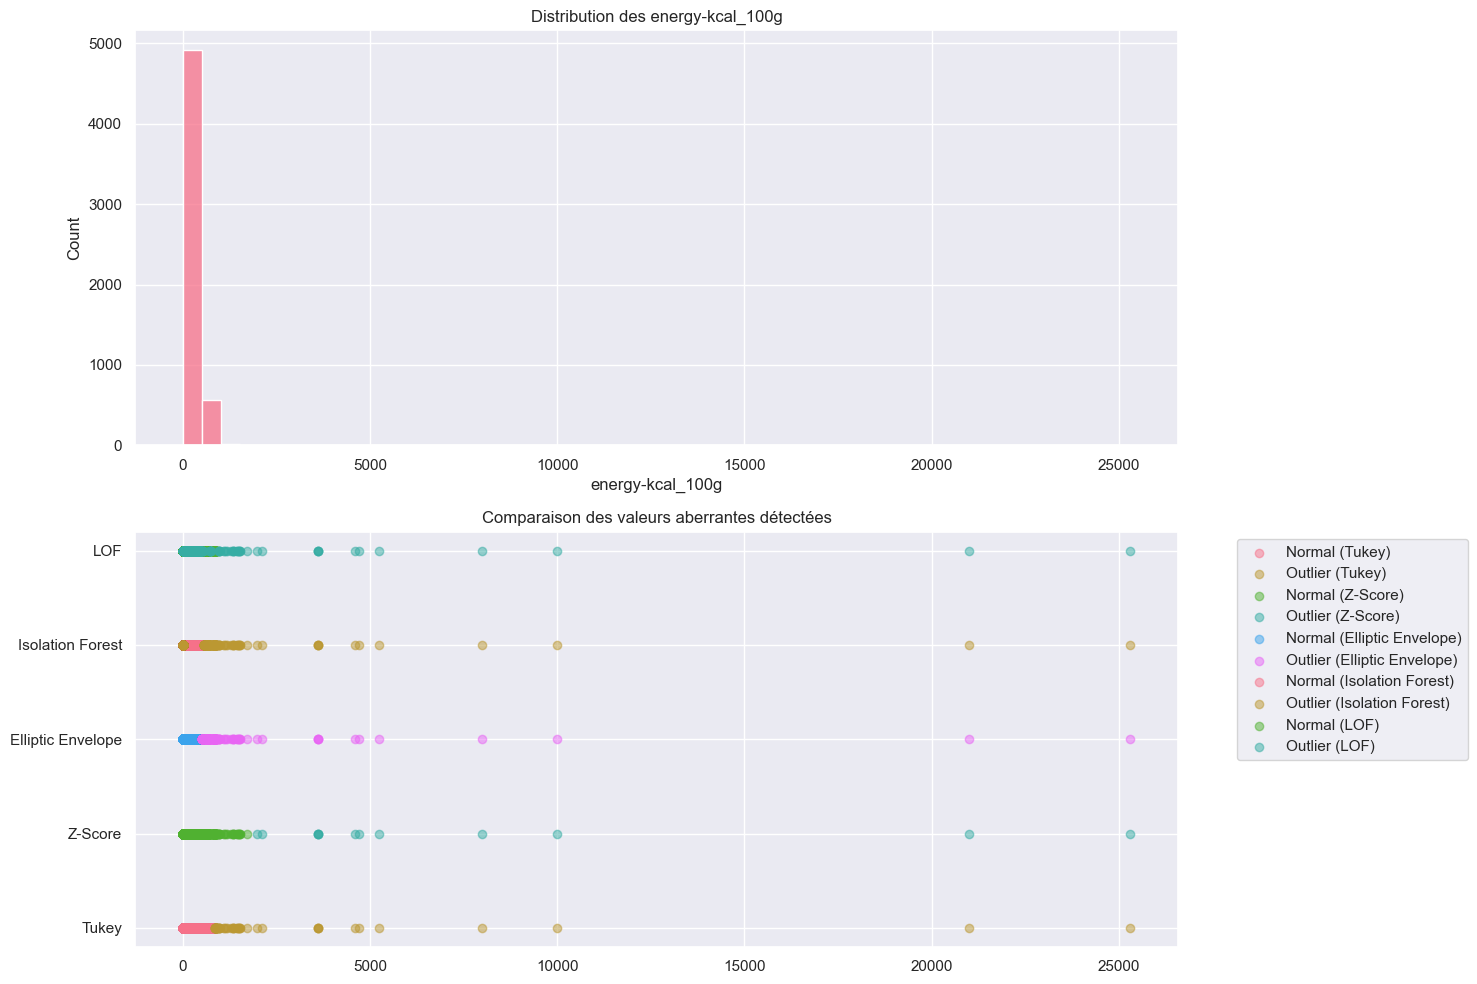


Analyse de la colonne : fat_100g

Résumé des détections de valeurs aberrantes :
--------------------------------------------------

Méthode : Tukey
Nombre de valeurs aberrantes : 311
Pourcentage : 5.87%
------------------------------

Méthode : Z-Score
Nombre de valeurs aberrantes : 49
Pourcentage : 0.93%
------------------------------

Méthode : Elliptic Envelope
Nombre de valeurs aberrantes : 528
Pourcentage : 9.97%
------------------------------

Méthode : Isolation Forest
Nombre de valeurs aberrantes : 529
Pourcentage : 9.99%
------------------------------

Méthode : LOF
Nombre de valeurs aberrantes : 530
Pourcentage : 10.01%
------------------------------


c:\Users\omist\OpenFoodFacts\teaching_ml_bis_2025\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


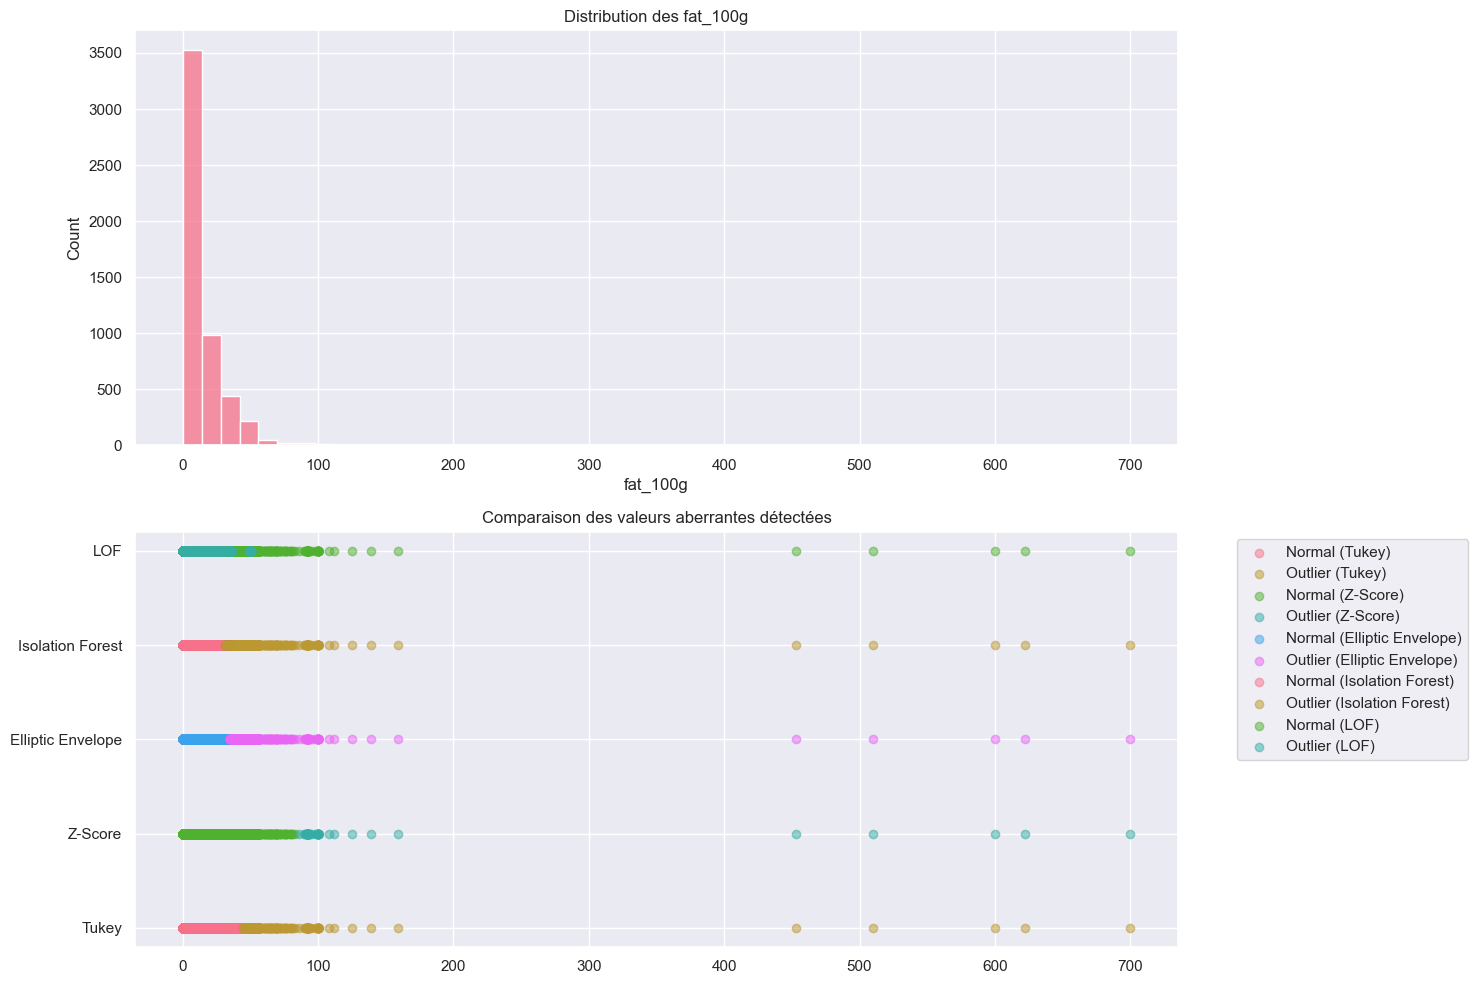


Analyse de la colonne : proteins_100g

Résumé des détections de valeurs aberrantes :
--------------------------------------------------

Méthode : Tukey
Nombre de valeurs aberrantes : 393
Pourcentage : 7.38%
------------------------------

Méthode : Z-Score
Nombre de valeurs aberrantes : 7
Pourcentage : 0.13%
------------------------------

Méthode : Elliptic Envelope
Nombre de valeurs aberrantes : 532
Pourcentage : 9.99%
------------------------------

Méthode : Isolation Forest
Nombre de valeurs aberrantes : 530
Pourcentage : 9.95%
------------------------------

Méthode : LOF
Nombre de valeurs aberrantes : 533
Pourcentage : 10.01%
------------------------------


c:\Users\omist\OpenFoodFacts\teaching_ml_bis_2025\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


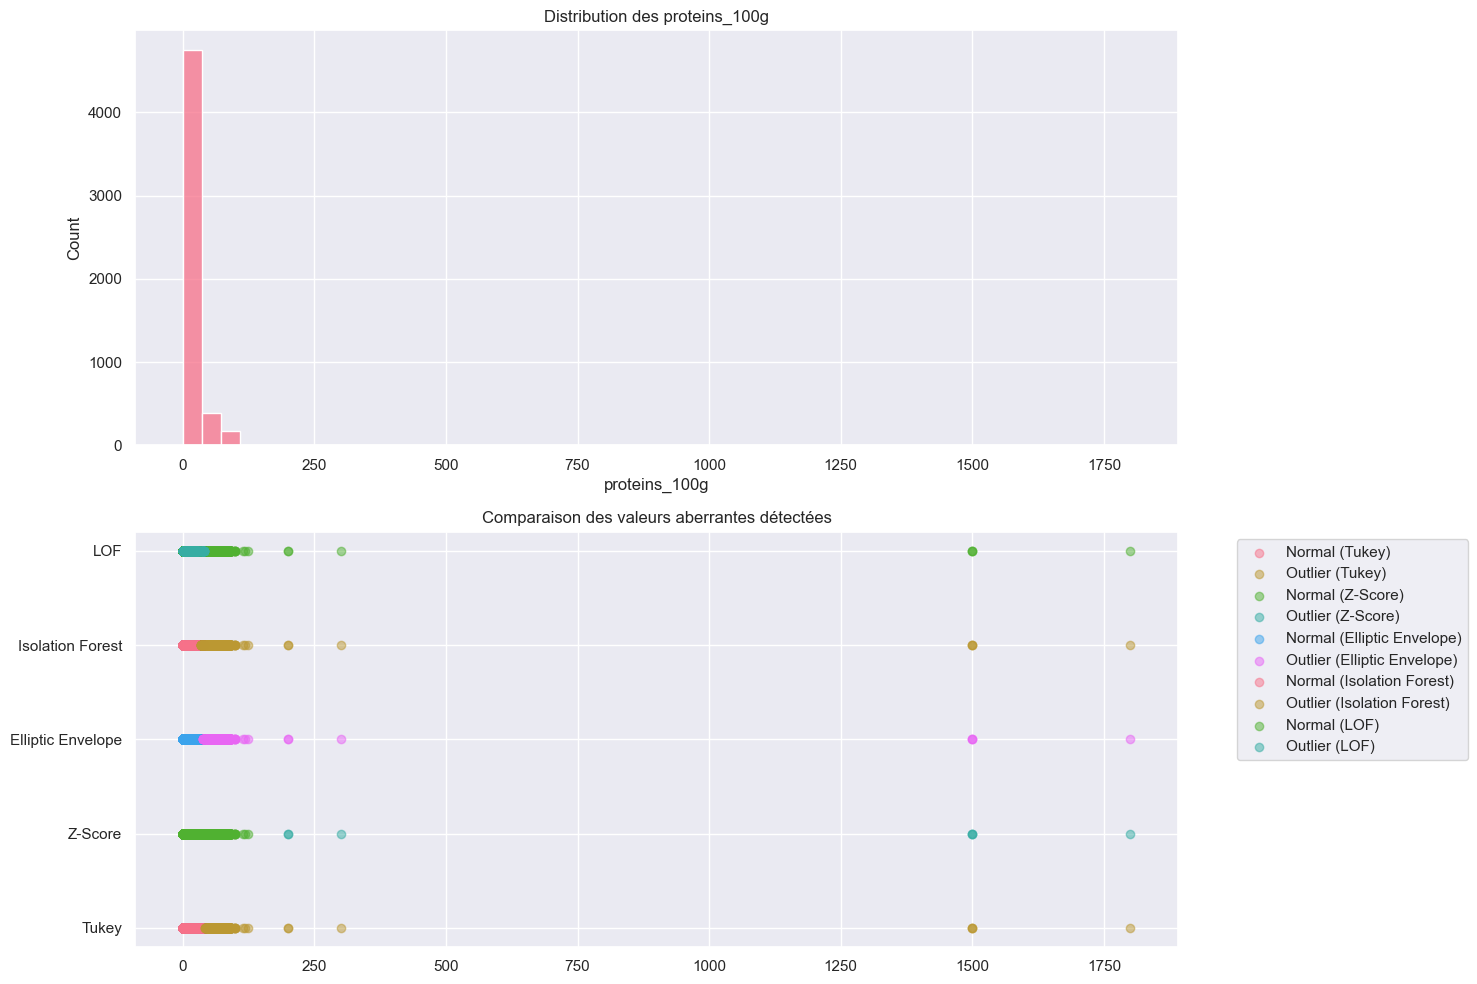


Analyse de la colonne : carbohydrates_100g

Résumé des détections de valeurs aberrantes :
--------------------------------------------------

Méthode : Tukey
Nombre de valeurs aberrantes : 50
Pourcentage : 0.92%
------------------------------

Méthode : Z-Score
Nombre de valeurs aberrantes : 29
Pourcentage : 0.54%
------------------------------

Méthode : Elliptic Envelope
Nombre de valeurs aberrantes : 542
Pourcentage : 10.00%
------------------------------

Méthode : Isolation Forest
Nombre de valeurs aberrantes : 542
Pourcentage : 10.00%
------------------------------

Méthode : LOF
Nombre de valeurs aberrantes : 542
Pourcentage : 10.00%
------------------------------


c:\Users\omist\OpenFoodFacts\teaching_ml_bis_2025\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


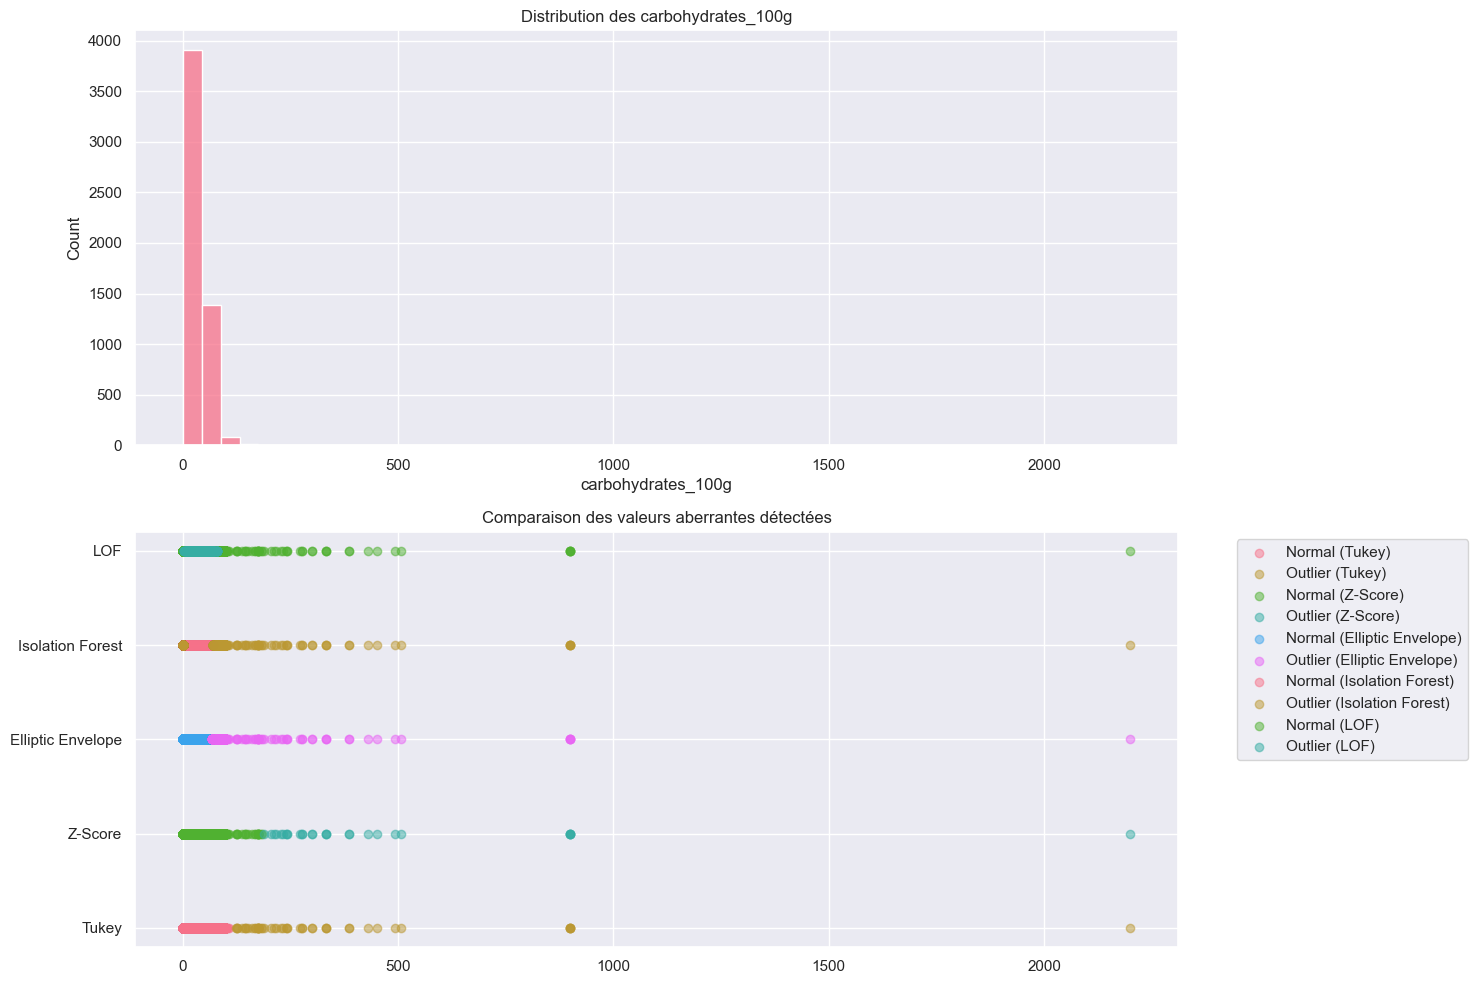

In [5]:
for column in numeric_columns:
    print(f"\nAnalyse de la colonne : {column}")
    
    # Nettoyage des données
    data = df[column].dropna()
    
    # Application des différentes méthodes
    methods_results = {
        'Tukey': detect_outliers_tukey(data),
        'Z-Score': detect_outliers_zscore(data),
        'Elliptic Envelope': detect_outliers_elliptic(data),
        'Isolation Forest': detect_outliers_isolation_forest(data),
        'LOF': detect_outliers_lof(data)
    }
    
    # Affichage des résultats
    print_summary(methods_results)
    
    # Création et affichage du graphique
    fig = plot_outliers_comparison(data, column, methods_results)
    plt.show()